# **RSNA-MICCAI Brain Tumor Radiogenomic Classification**
**Predict the status of a genetic biomarker important for brain cancer treatment**

# **Imports and variable declarations**

This section contains the libraries used in the notebook as well as the variables relating to the parameters of the generated network.

In [1]:
import os # os functionalities
import re # regular expressions
import warnings # avoid tf warnings
import numpy as np # linear algebra
import pandas as pd # data processing
from skimage import io # image manipulation
from matplotlib import pyplot as plt # image visualization
warnings.filterwarnings('ignore') # ignore tensorflow warnings

import seaborn as sns

# Tensorflow & Keras & SkLearn
import keras
import tensorflow as tf 
from tensorflow.keras.metrics import AUC # area under ROC curve
from keras.applications.vgg16 import VGG16 # pretrained model
from sklearn.model_selection import train_test_split # divide dataset
from sklearn.metrics import confusion_matrix # metrics for assesing the model

In [2]:
# Variable declaration
'''
Images for an specific patient are selected following one of these criteria
    - central: Since all the images of the same patient are ordered by their id, the one in the middle is seletected
    - first: Select the first one to appear
    - all: Select all the available images for a given patient
'''
patient_mode = "all" # all - central - first 
image_modes = ["FLAIR"] # FLAIR - T1w - T1wCE - T2w
#image_modes = ["T2w"] # FLAIR - T1w - T1wCE - T2w

# Paths to images
input_dir = "../input/rsna-miccai-png/train" 
target_dir = "../input/rsna-miccai-png/test"

# Model variables
epochs = 25
batch_size = 32
learning_rate = 0.01
optimizer = "RMSprop"
data_augmentation = False
loss_function = "binary_crossentropy"

# **Data loading**

In [3]:
def prepare_data(image_mode, patient_mode):
    """
    This function prepares the paths to the images and gets the labels for each image
    :parameter image_mode: Type of the images to be loaded (FLAIR - T1w - T1wCE - T2w)
    :parameter patient_mode: Criteria for selecting the specific images of a patient that are going to be used
    :return input_img_paths: List of paths to the images
    :return labels: List of labels for each image
    """

    # Get path to the training images
    input_img_paths_patients = sorted([
        os.path.join(input_dir, fname + "/" + image_mode) 
        for fname in os.listdir(input_dir)
        if os.path.exists(os.path.join(input_dir, fname + "/" + image_mode))])

    # Get images id's by a specific criteria
    input_img_paths = []
    for patient in input_img_paths_patients:
        images_id = x = [int(re.findall(r'\d+', x)[0]) for x in os.listdir(patient)] # Get all image ids
        '''
        Images for an specific patient are selected following one of these criteria
        - central: Since all the images of the same patient are ordered by their id, the one in the middle is seletected
        - first: Select the first one to appear
        - all: Select all the available images for a given patient
        '''
        if patient_mode == "central":  # Get middle image
            index_central_image = min(images_id) + round((max(images_id) - min(images_id))/2)
            path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
            if os.path.exists(path): input_img_paths.append(path)
        if patient_mode == "first": # Get first image
            index_central_image = min(images_id) 
            path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
            if os.path.exists(path): input_img_paths.append(path)
        if patient_mode == 'all': # Add all of the available images
            for image in images_id:
                path = os.path.join(patient, "Image-" + str(image) + ".png")
                if os.path.exists(path): input_img_paths.append(path)

    # Read csv labels
    df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

    # Obtain pure labels
    labels = []
    for img_path in input_img_paths:
        labels.append(df.loc[df['BraTS21ID'] == int(re.findall(r'\d+', img_path)[0])]['MGMT_value'].iloc[0])
        
    return input_img_paths, labels

In [4]:
def split_data(input_img_paths, labels, verbose=True):
    """
    This function splits the data between the training, validation and test sets
    :parameter input_img_paths: List of paths to the images
    :parameter labels: List of labels for each image
    :return train_df: Dataframe containing paths and labels of the training set
    :return val_df: Dataframe containing paths and labels of the validation set
    :return test_df: Dataframe containing paths and labels of the test set
    """
    
    # Split data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(input_img_paths, labels, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42) # 0.111*0.9 = 0.1

    # Check amounts of data in each split
    if verbose:
        print(f"Training samples: {str(len(X_train))}\nValidation samples: {str(len(X_val))}\nTest samples: {str(len(X_test))}\n")

    # Create dataframes for keras flow_from_dataframe
    data = {'id': X_train, 'label': [str(x) for x in y_train]}
    train_df = pd.DataFrame(data)

    data = {'id': X_val, 'label': [str(x) for x in y_val]}
    val_df = pd.DataFrame(data)

    data = {'id': X_test, 'label': [str(x) for x in y_test]}
    test_df = pd.DataFrame(data)
    
    return train_df, val_df, test_df

In [5]:
def get_data_generators(train_df, val_df, test_df, data_augmentation=False):
    """
    This function loads the dataset from dataset folder and returns the image generators associated
    :parameter train_df: Dataframe with paths to training images and labels
    :parameter val_df: Dataframe with paths to validation images and labels
    :parameter test_df: Dataframe with paths to test images and labels
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """

    # Create a data generator
    if data_augmentation:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                        rotation_range=20,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        zoom_range=0.2,
                                                                        horizontal_flip=True)
    else:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
        
    datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Load and iterate training dataset
    train_generator=datagen_train.flow_from_dataframe(dataframe=train_df, x_col="id", y_col="label", 
                                                      class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate validation dataset
    val_generator=datagen_val_test.flow_from_dataframe(dataframe=val_df, x_col="id", y_col="label", 
                                                       class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate test dataset
    test_generator=datagen_val_test.flow_from_dataframe(dataframe=test_df, x_col="id", y_col="label", 
                                                        class_mode="binary", batch_size=batch_size, target_size=(224, 224))

    return train_generator, val_generator, test_generator

In [6]:
def load_dataset(image_mode, patient_mode, data_augmentation):
    """
    This function loads the dataset for a given image mode
    :parameter image_mode: Type of the images to be loaded (FLAIR - T1w - T1wCE - T2w)
    :parameter patient_mode: Criteria for selecting the specific images of a patient that are going to be used
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """
    
    input_img_paths, labels = prepare_data(image_mode, patient_mode)
    train_df, val_df, test_df = split_data(input_img_paths, labels)
    train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, data_augmentation)
    
    return train_generator, val_generator, test_generator

## **Data visualization**

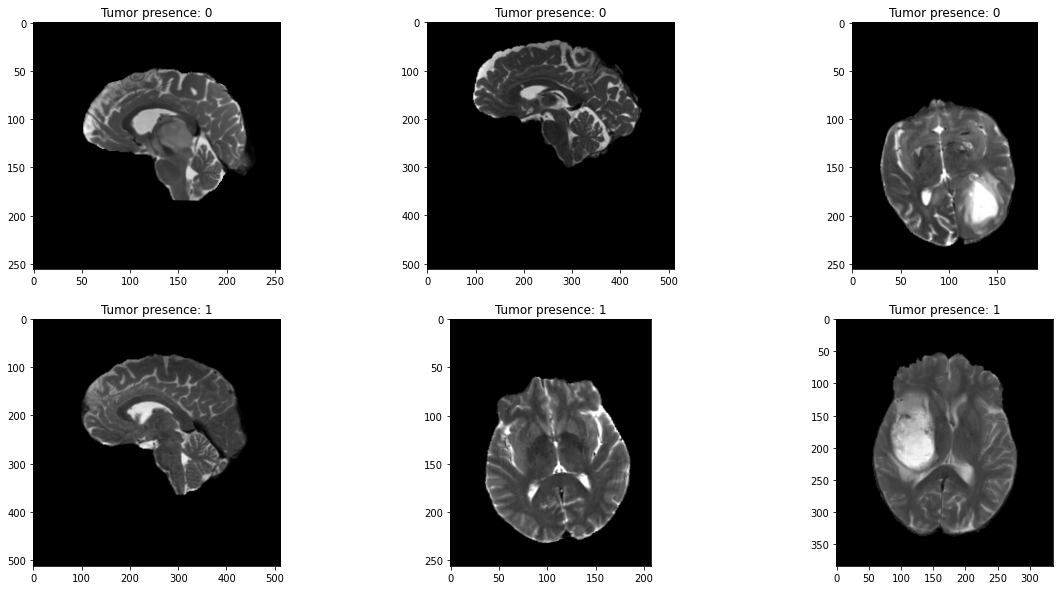

In [7]:
# Load images
input_img_paths, labels = prepare_data("T2w", "central")
train_df, val_df, test_df = split_data(input_img_paths, labels, verbose=False)

samples = 3 # Number of samples to select of each label

# samples are obtained for no tumor and tumor
selected = pd.concat([train_df[train_df.label.eq('0')].sample(samples), train_df[train_df.label.eq('1')].sample(samples)])

# Create figure
fig = plt.figure(figsize=(20, 10))

# Setting values to rows and column variables
rows = 2
columns = samples

# Plot images
for element in range(0, len(selected)):
    fig.add_subplot(rows, columns, element + 1)
    plt.imshow(io.imread(list(selected['id'])[element]), cmap='gray')
    plt.title(f"Tumor presence: {list(selected['label'])[element]}")

# **Model definition**

In [8]:
def define_model(verbose=False):
    """
    This function defines the convolutional neural network model to be used
    :return train_generator: Training generator
    """
    
    # Free up RAM in case the model definition cells were run multiple times
    keras.backend.clear_session()

    # Build model
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

    # Make sure that the base_model is running in inference mode here, by passing `training=False`
    base_model.trainable = False

    # Define model structure
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    # Dense classifier for binary classification
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    if verbose:
        model.summary()

    return model

In [9]:
# Choose optimizer - SGD - RMSprop - Adam
if optimizer == "SGD": 
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop":
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else: 
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7, amsgrad=True)

# **Model training**

In [10]:
def train_model(model, fit_optimizer, loss_function, epochs, train_generator, val_generator, image_mode):
    """
    This function trains a given model with the parameters specified the dataset for a given image mode
    :parameter model: Keras model to be trained 
    :parameter fit_optimizer: Optimizers to compute the moving average and overwrite the model variables at desired time
    :parameter loss_function: Objective function
    :parameter epochs: Number of episodes to trained the model
    :parameter training_generator: Training generator
    :parameter val_generator: Validation generator
    :parameter image_mode: Type of the images to be loaded (FLAIR - T1w - T1wCE - T2w)
    :return model: Keras model trained
    :return model_history: Model training history 
    """
    
    # Free up RAM in case the model definition cells were run multiple times
    keras.backend.clear_session()
    
    # Configure the model for training.
    model.compile(optimizer=fit_optimizer, loss=loss_function, metrics=['accuracy', AUC()])

    # Safe best model and Early Stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]

    # Train the model, doing validation at the end of each epoch.
    model_history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)
    
    return model, model_history

In [11]:
# Store models, scores, training histories and test generators into dictionaries
models = {}
scores = {}
model_histories = {}
test_generators = {}

# Train a model for each image_mode available
for image_mode in image_modes:
    print(f"\nTraining with: {image_mode} images\n")
    
    # Prepare and load data
    train_generator, val_generator, test_generator = load_dataset(image_mode, patient_mode, data_augmentation)

    # Define model
    model = define_model()

    # Train model
    model, model_histories[image_mode] = train_model(model, fit_optimizer, loss_function, epochs, train_generator, val_generator, image_mode)
    models[image_mode] = model
    
    # Evaluate the model
    test_generators[image_mode] = test_generator
    test_generator.reset()
    scores[image_mode] = model.evaluate(test_generator, verbose=0)
    print(f"\nLoss: {str(scores[image_mode][0])} \nAccuracy on test: {str(scores[image_mode][1])}\nAUC: {str(scores[image_mode][2])}\n")


Training with: FLAIR images

Training samples: 42950
Validation samples: 5363
Test samples: 5369

Found 42950 validated image filenames belonging to 2 classes.
Found 5363 validated image filenames belonging to 2 classes.
Found 5369 validated image filenames belonging to 2 classes.


2022-12-11 17:43:22.752359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 17:43:22.832720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 17:43:22.833500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 17:43:22.835124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 3s 0us/step


2022-12-11 17:43:29.256512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-11 17:43:31.358149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1343/1343 [==============================] - 411s 299ms/step - loss: 0.6764 - accuracy: 0.5906 - auc: 0.5629 - val_loss: 0.6674 - val_accuracy: 0.5967 - val_auc: 0.6055
Epoch 2/25
1343/1343 [==============================] - 152s 113ms/step - loss: 0.6618 - accuracy: 0.6045 - auc: 0.6075 - val_loss: 0.6715 - val_accuracy: 0.6135 - val_auc: 0.6177
Epoch 3/25
1343/1343 [==============================] - 148s 110ms/step - loss: 0.6540 - accuracy: 0.6081 - auc: 0.6281 - val_loss: 0.6510 - val_accuracy: 0.6155 - val_auc: 0.6340
Epoch 4/25
1343/1343 [==============================] - 149s 111ms/step - loss: 0.6486 - accuracy: 0.6111 - auc: 0.6396 - val_loss: 0.6566 - val_accuracy: 0.6164 - val_auc: 0.6395
Epoch 5/25
1343/1343 [==============================] - 155s 115ms/step - loss: 0.6441 - accuracy: 0.6185 - auc: 0.6494 - val_loss: 0.6495 - val_accuracy: 0.6099 - val_auc: 0.6358
Epoch 6/25
1343/1343 [==============================] - 148s 110ms/step - loss: 0.6414 - accuracy: 0.6220 - auc

# **Models evaluation**

In [12]:
scores

{'FLAIR': [0.6289928555488586, 0.6349413394927979, 0.6774752140045166]}

In [13]:
# Get best model
best_model = list(scores.keys())[0]
for image_mode in scores:
    if scores[image_mode][2] > scores[best_model][2]:
        best_model = image_mode
        
# Serialize and save model to json
model_json = models[best_model].to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize and save weights to HDF5
models[best_model].save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


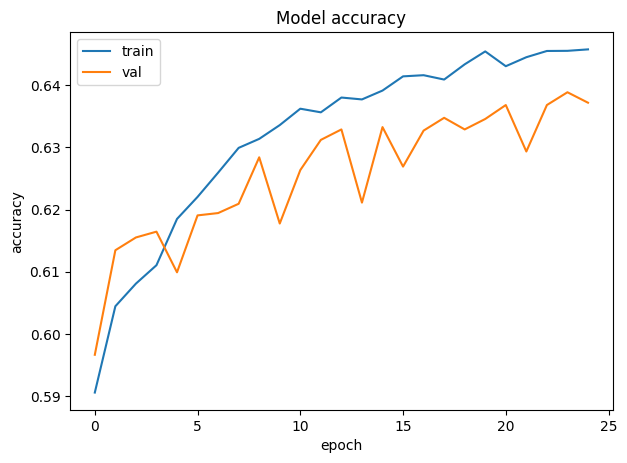

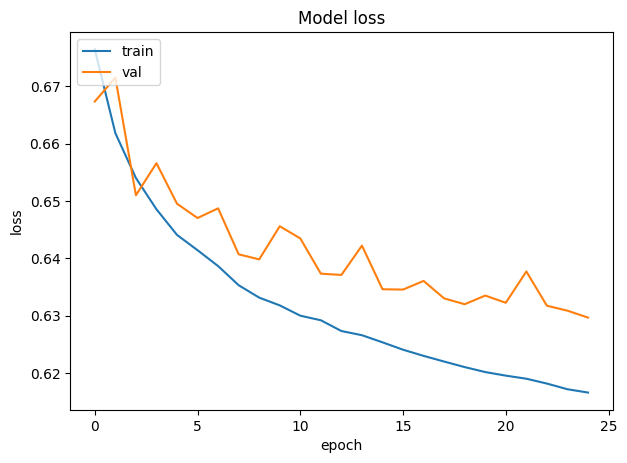

In [14]:
# Accuracy plot to show the evolution of the training process of the best model
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(model_histories[best_model].history['accuracy'])
plt.plot(model_histories[best_model].history['val_accuracy'])
plt.title(f'Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'Brain_Tumor_accuracy.pdf')
plt.show()
plt.close()

# Loss plot to show the evolution of the training process of the best model
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(model_histories[best_model].history['loss'])
plt.plot(model_histories[best_model].history['val_loss'])
plt.title(f'Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'Brain_Tumor_loss.pdf')
plt.show()
plt.close()

In [15]:
# Evaluate the model
test_generators[best_model].reset()
score = models[best_model].evaluate(test_generators[best_model], verbose=0)
print(f"Loss: {str(score[0])} \nAccuracy on test: {str(score[1])}\nAUC: {str(score[2])}")

Loss: 0.6289927959442139 
Accuracy on test: 0.6349413394927979
AUC: 0.6774752140045166


In [16]:
# Assign most probable label to predictions
test_generators[best_model].reset()
pred = models[best_model].predict(test_generators[best_model], verbose=0)
predicted_class_indices = np.round(pred)

# Get class labels
target_names = (test_generators[best_model].class_indices).keys()

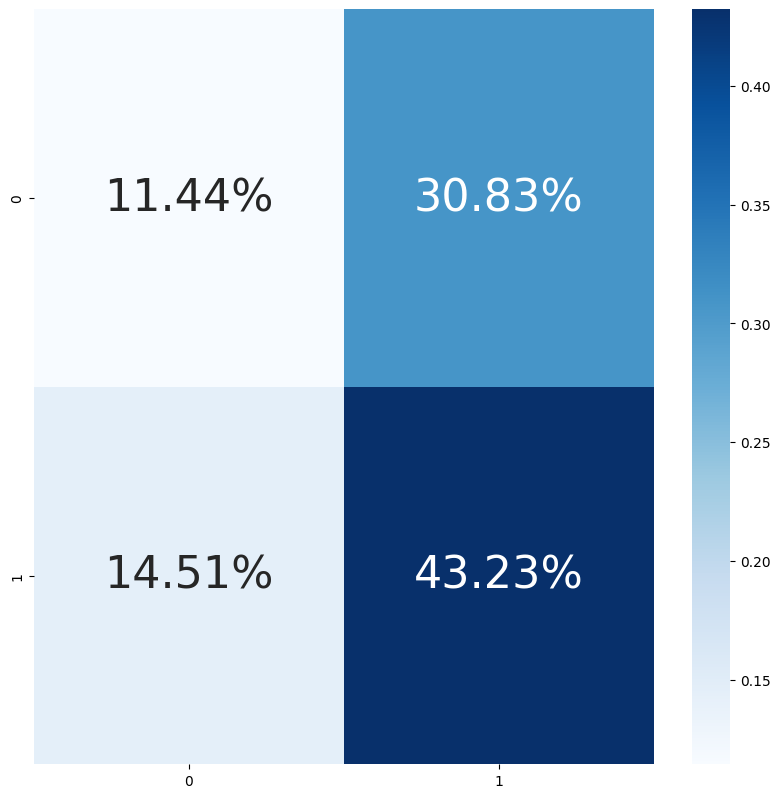

In [17]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
cf_matrix = confusion_matrix(np.array(test_generators[best_model].classes), predicted_class_indices)
heatmap = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues', cbar=True, square=False, 
                      annot_kws={"fontsize":32}, xticklabels=target_names, yticklabels=target_names)
fig = heatmap.get_figure()
plt.savefig(f'Brain_Tumor_confusion_matrix.pdf')